##  Car Price Project - Algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Model selection
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import mean_squared_error

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Score predictions of fitted model.
def score_algo(model, X, y, prediction):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    print(' MAE:', round(mean_absolute_error(y, prediction),1))

In [3]:
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

In [4]:
#Read in data tables.  Put quotes around table to make case-sensitive.
vehicle=pd.read_sql('SELECT * from vehicle', engine, index_col='index')
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
vehicle.index.name=None; train.index.name=None; test.index.name=None;

##  Nonlinear Models - LightGBM

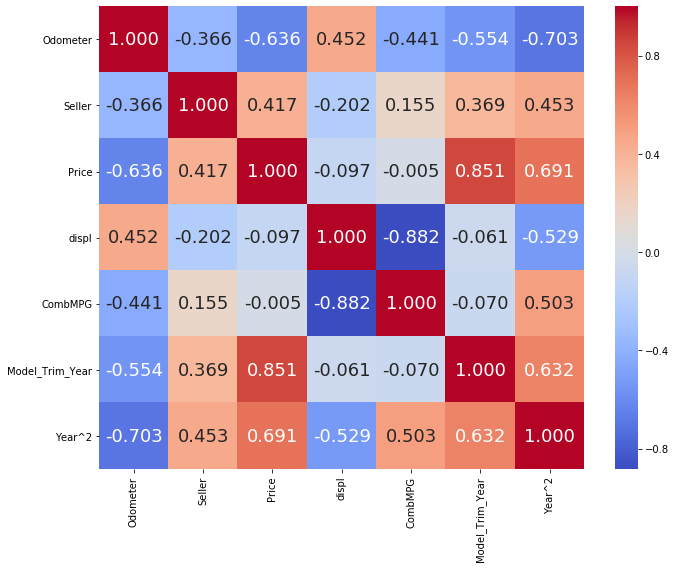

In [5]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 18}, fmt=".3f")
plt.tight_layout()

<a id='section_id1'></a>

### LightGBM model

In [6]:
#Split out Price
trainX = train.copy()
trainY = trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

In [7]:
trainX.head(2)

,Odometer,Seller,displ,CombMPG,Model_Trim_Year,Year^2
6803,145887.995628,7846.639162,4.128084,18.072878,12844.098053,4036081.0
15677,77052.995061,15741.258162,2.000000,29.000000,10658.592487,4068289.0


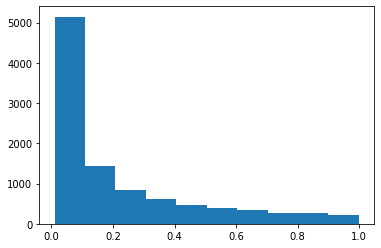

In [8]:
#Log uniform distribution from scikit-optimize
plt.hist(Real(0.01, 1.0, 'log-uniform').rvs(n_samples=10000))
plt.show()

In [9]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,200),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30, cv=5, n_jobs=-1, refit=True,\
                           scoring='neg_mean_absolute_error', return_train_score=False,random_state=40)

#Tune model with CV. Model will automatically refit on full train with best parameters.
lgb_model.fit(trainX, trainY)

#Tuned model best score.
best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}','\n')
mean_score = np.round(lgb_model.cv_results_["mean_test_score"],0)
print(f'## mean valid scores: {mean_score})', '\n')
print(f'## best valid score: {lgb_model.best_score_:.0f} +- {best_score_std:.0f}','\n')   
print('## Best parameters:')
pprint.pprint(lgb_model.best_params_)

## Grid iters checked: 30 

## mean valid scores: [-2310. -2258. -2193. -2549. -2225. -2418. -2507. -2295. -2257. -3350.
 -2633. -2274. -2270. -3787. -2181. -2455. -2289. -2250. -2316. -2206.
 -2208. -2275. -2654. -2367. -3186. -2233. -2194. -2193. -2190. -2201.]) 

## best valid score: -2181 +- 43 

## Best parameters:
{'bagging_fraction': array([0.04935058]),
 'feature_fraction': 0.42947550640925103,
 'lambda_l1': array([4.21134118e-07]),
 'lambda_l2': array([0.12869787]),
 'learning_rate': array([0.15093011]),
 'max_bin': 30552,
 'max_depth': 17,
 'min_data_in_leaf': 25,
 'n_estimators': 138,
 'num_leaves': 471,
 'subsample_for_bin': 165596}


In [10]:
# #SAVE model
# joblib.dump(lgb_model, 'lgb_model.joblib', compress=0)

# #LOAD model
# lgb_model = joblib.load('lgb_model.joblib')

In [11]:
#PREDICT model on full data (thanks to refit).
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_test_pred = lgb_model.predict(testX)
score_algo(lgb_model, testX, testY, y_test_pred)

-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3165.0
 R^2: 0.8722
 MAE: 2184.3


In [12]:
#Get feature importances using eli5.
perm = PermutationImportance(lgb_model, n_iter=30).fit(testX, testY)
eli5.show_weights(perm, feature_names = testX.columns.tolist())

Weight,Feature
2121.7823 ± 205.6216,Model_Trim_Year
1688.1214 ± 208.3197,Year^2
1514.3596 ± 195.1923,Odometer
933.6805 ± 132.2725,displ
722.4177 ± 104.2800,CombMPG
244.4998 ± 79.3408,Seller


#### Residuals Plot Function

In [13]:
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots error histogram.  Plots regression of predicted vs true.
    Returns indices of 3 sigma anomalies.
    '''
    anomaly_locs = []
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std; lower_lim = mean - three_std;
    sns.set(font_scale=1.3)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted'); ax1.set_ylabel('Error - True less Predicted');
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            anomaly_locs.append(true.iloc[elem:elem+1].index[0])
            ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error'); ax2.set_ylabel('Frequency');
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted'); ax3.set_ylabel('True');
    return anomaly_locs

In [14]:
train.head(2)

,Odometer,Seller,Price,displ,CombMPG,Model_Trim_Year,Year^2
6803,145887.995628,7846.639162,8250.0,4.128084,18.072878,12844.098053,4036081.0
15677,77052.995061,15741.258162,3995.0,2.000000,29.000000,10658.592487,4068289.0


In [15]:
# #Review loc
# pd.set_option('max_colwidth', 100)
# for locNum in [4777]:
#     iloc = np.where(trainX.index==locNum)[0][0]
#     display('### modeled train:', trainX.loc[[locNum]])
#     print('true:', trainY.loc[locNum])
#     print('predicted:', y_trn_pred[iloc])
#     print('error:', trainY.loc[locNum] - y_trn_pred[iloc])
#     display('### original:', vehicle.loc[[locNum]])
#     display(vehicle.loc[locNum,'Body'])
#     print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

error count: 4107 | error avg: 0.0 | high pred percent: 51.2 | low pred percent: 48.8


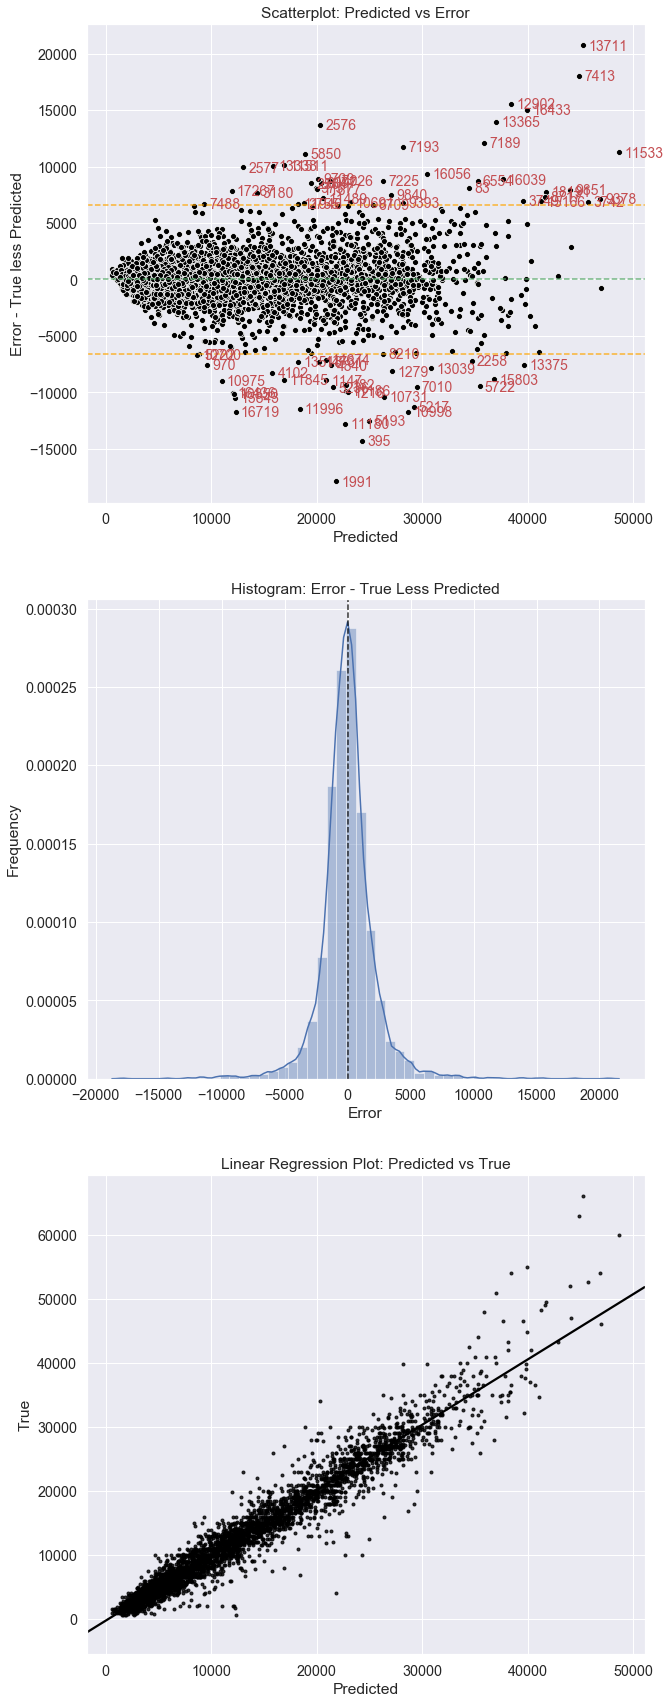

In [16]:
#LightGBM - Plot train residuals.
y_trn_pred = lgb_model.predict(trainX)
anomal = plot_residuals(predicted=y_trn_pred, true=trainY)

error count: 456 | error avg: -180.8 | high pred percent: 52.4 | low pred percent: 47.6


[10495, 17701, 12897, 12540, 15182, 4668, 7420]

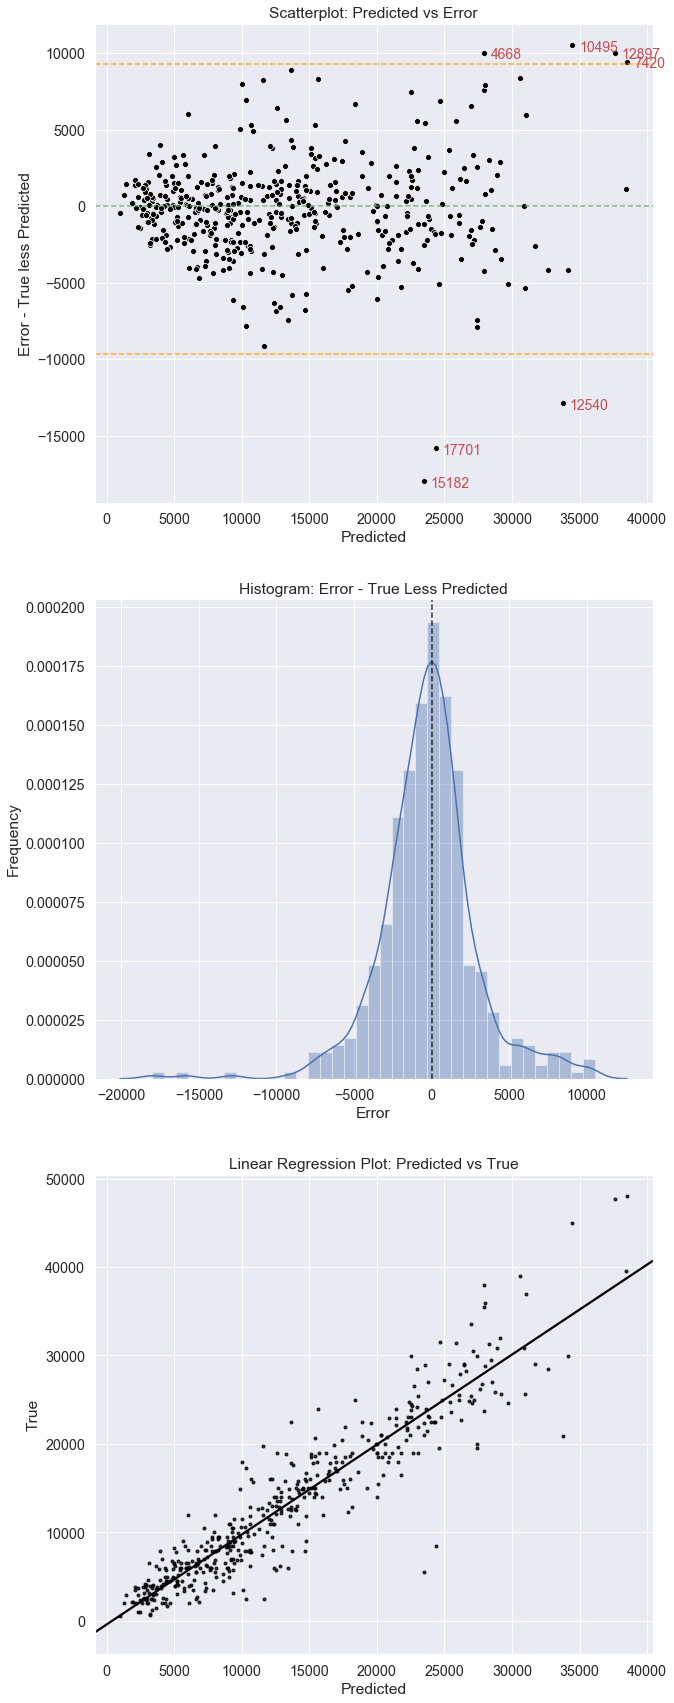

In [17]:
#LightGBM - Plot test residuals.
plot_residuals(predicted=y_test_pred, true=testY)

## Linear Regression Model

In [18]:
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
train.index.name=None; test.index.name=None; 
train.shape

(4107, 7)

In [19]:
train.head(1)

,Odometer,Seller,Price,displ,CombMPG,Model_Trim_Year,Year^2
6803,145887.995628,7846.639162,8250.0,4.128084,18.072878,12844.098053,4036081.0


In [20]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

In [21]:
def scale_num_df(train_df, test_df, numer_cols, scaler):
    '''Scale train.  Transform test with the same scaling stats.
    Returns scaled train and scaled test.'''
    from sklearn.preprocessing import RobustScaler
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    return scaled_trn_num_df, scaled_tst_num_df

#Standard scale so regression coefficient units are the same.
trainX, testX = scale_num_df(trainX.copy(), testX.copy(), trainX.columns, StandardScaler())

In [22]:
trainX.describe().round(2)

,Odometer,Seller,displ,CombMPG,Model_Trim_Year,Year^2
count,4107.00,4107.00,4107.00,4107.00,4107.00,4107.00
mean,0.00,-0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.81,-1.32,-1.79,-1.75,-1.58,-3.18
25%,-0.83,-1.32,-0.95,-0.73,-0.72,-0.70
50%,-0.02,0.76,-0.01,-0.19,-0.20,0.26
75%,0.70,0.76,0.78,0.35,0.51,0.84
max,5.14,0.76,1.77,2.96,3.90,1.61


### One-Hot Encode

In [23]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [24]:
# #Get One-Hot columns for the specified categ_columns.
# categ_cols= trainX.select_dtypes('object').columns.values
# ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX, test_df=testX, cat_cols=categ_cols)

# #Drop original category columns.  Concatenate the One-Hot columns.
# trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
# testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

# trainX = pd.concat([trainX, ohe_train_df], axis='columns')
# testX = pd.concat([testX, ohe_test_df], axis='columns')
# display('trainX:', trainX.head(2))
# display('testX:', testX.head(2))

## `Tune Linear Models with Cross Validation`

In [25]:
def train_and_valid(what_model, num_folds, X, y):
    fold_rmse=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rmse.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold RMSE:', fold_rmse)
    print('## Avg RMSE:', round(np.mean(fold_rmse),1),'+-', round(np.std(fold_rmse),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model

In [26]:
#Linear regression finds the coeficcients that minimize the residual sum of squares.
lr=LinearRegression(fit_intercept=True)
lr_clone=train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)

***Tune LinearRegression***
## Fold RMSE: [4345.55, 4389.74, 3707.53, 4488.22, 3865.25, 3849.62, 3533.28, 3709.26, 4026.86, 4247.86]
## Avg RMSE: 4016.3 +- 315.9
## Clone R^2: 0.803


In [27]:
#Score last lr_clone on train (same data it was fitted on once).
y_pred_clone = lr_clone.predict(trainX)
score_algo(lr_clone, trainX, trainY, y_pred_clone)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
RMSE: 4022.0
 R^2: 0.8029
 MAE: 2702.0


In [28]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=20).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
0.4664 ± 0.0215,Model_Trim_Year
0.2189 ± 0.0132,Year^2
0.1062 ± 0.0062,CombMPG
0.1059 ± 0.0067,Odometer
0.0034 ± 0.0011,Seller
0.0006 ± 0.0004,displ


## `Linear Model Predictions - Fit on 100% of train`

In [29]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution, only for coefficient
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
score_algo(linregr, testX, testY, y_pred_linregr)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
RMSE: 4057.6
 R^2: 0.79
 MAE: 2844.3


In [30]:
#Linear Regression Coefficients. Each feature has the same scale: value per unit of standard deviation.
pd.DataFrame({'feature': trainX.columns, 'coef' : np.round(linregr.coef_,2)})

,feature,coef
0,Odometer,-2077.76
1,Seller,406.02
2,displ,161.43
3,CombMPG,-2058.37
4,Model_Trim_Year,4405.04
5,Year^2,2953.11


error count: 456 | error avg: -225.1 | high pred percent: 55.5 | low pred percent: 44.5


[10495, 17850, 12897, 10403, 15182, 7420]

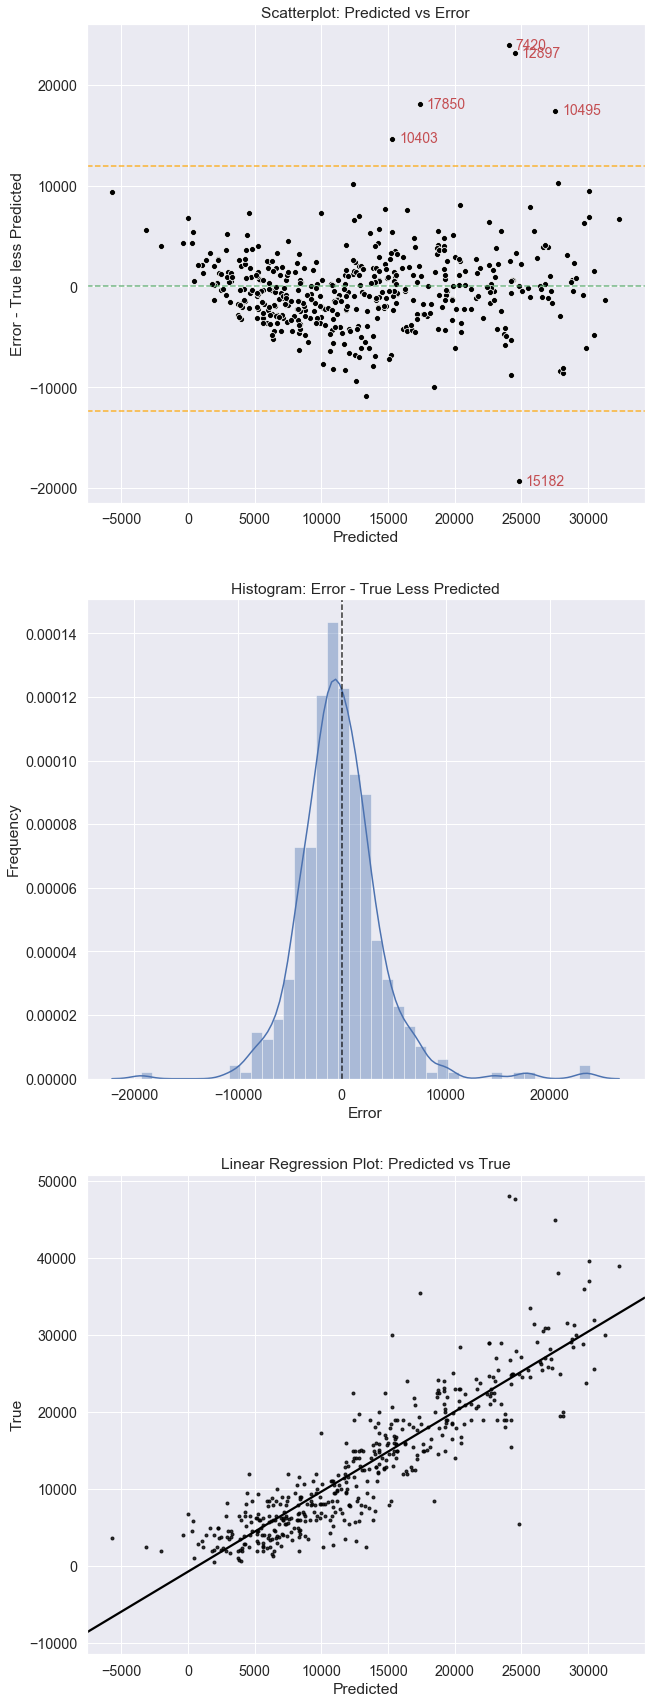

In [31]:
#Get test residuals.  A non-normal error means errors are not random.  Are there outliers?  Try transforming features
#to make them closer to normally distributed.  We will not go down this path today as we have a more accurate LightGBM
#model with better-looking residuals.  LightGBM can model non-linear relationships, in contrast to a linear regression.
plot_residuals(predicted=y_pred_linregr, true=testY)

In [32]:
# def get_anomalies(trainX, testX):
#     '''Return anomalies from trainX and testX.'''
#     #Instantiate, fit, and predict with Isolation Forest.
#     isof = IsolationForest(n_estimators = 200, max_samples ='auto', max_features=1.0, contamination=0.05,
#                            behaviour='deprecated', n_jobs=-1, random_state=33)
#     trn_preds = isof.fit_predict(trainX)
#     tst_preds = isof.predict(testX)

#     #Save outliers (-1) to indexed series.
#     trn_preds = pd.Series(data=trn_preds, index=trainX.index, name='OutlierTrn')
#     trn_anom = trn_preds[trn_preds == -1]
#     tst_preds = pd.Series(data=tst_preds, index=testX.index, name='OutlierTst')
#     tst_anom = tst_preds[tst_preds == -1]

#     #Print anomalies found.
#     trn_drops = trn_anom.index
#     tst_drops=tst_anom.index
#     print(f'## {len(trn_drops)} trainX anomalies flagged by Isolation Forest:', trn_drops)       
#     print(f'\n## {len(tst_drops)} testX anomalies flagged by Isolation Forest:', tst_drops)
    
#     return trn_drops, tst_drops

# #Get trainX and testX anomalies.  Assumes same contamination level.
# trainX_anom, testX_anom  = get_anomalies(trainX=trainX, testX=testX)

# #Drop train anomalies and test anomalies.
# trainX.drop(index = trainX_anom, inplace=True, errors = 'ignore')
# trainY.drop(index = trainX_anom, inplace=True, errors = 'ignore')

# testX.drop(index = testX_anom, inplace=True, errors = 'ignore')
# testY.drop(index = testX_anom, inplace=True, errors = 'ignore')